In [147]:
import geopandas as gpd
import fiona

gdb_path = '../datasets/streets/lion.gdb'

layers = fiona.listlayers(gdb_path)
print("Layers in the Geodatabase:", layers)

layer_name = "lion"

gdf = gpd.read_file(gdb_path, layer=layer_name)

Layers in the Geodatabase: ['node', 'node_stname', 'altnames', 'lion']


Metadata can be found on https://home.nyc.gov/site/planning/data-maps/open-data/dwn-lion.page

I will use only the street names, codes and spatial data

In [148]:
gdf[['Street', 'ArcCenterX', 'ArcCenterY', 'XFrom', 'YFrom', 'XTo', 'YTo', 'StreetCode', 'geometry']][gdf['ArcCenterX'] != 0].head(1)


,Street,ArcCenterX,ArcCenterY,XFrom,YFrom,XTo,YTo,StreetCode,geometry
42,WEST 250 STREET,1010955,266182,1011029,265984,1010849,265998,275160,"MULTILINESTRING ((1011029.339 265983.646, 1011..."


In [149]:
import pandas as pd

df = pd.DataFrame(gdf[['Street', 'StreetCode', 'geometry']])

In [150]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

Example of finding the centroid per street and latitude and longitude

In [151]:
from shapely.ops import unary_union
from pyproj import Transformer
from shapely.geometry import shape

# find duplicates
duplicates = df[df.duplicated(subset=['Street'], keep=False)].sort_values(by='Street')
duplicates.reset_index(drop=True, inplace=True)

# Assuming 'duplicates' is a GeoDataFrame with a 'geometry' column
filtered = duplicates[duplicates['StreetCode'] == '110010']
print(filtered.head(1))

# Merge the geometries into a single geometry
merged_geometry = unary_union(filtered['geometry'])

# Calculate the centroid of the merged geometry
centroid = merged_geometry.centroid

# Assuming the original CRS is EPSG:2263 (NAD83 / New York Long Island)
# and we want to convert it to EPSG:4326 (WGS84)
transformer = Transformer.from_crs("EPSG:2263", "EPSG:4326", always_xy=True)

# Transform the centroid coordinates to latitude and longitude
lon, lat = transformer.transform(centroid.x, centroid.y)

print(f"Centered Latitude: {lat}, Centered Longitude: {lon}")

     Street StreetCode                                           geometry
0  1 AVENUE     110010  MULTILINESTRING ((993339.758 213416.489, 99337...
Centered Latitude: 40.758809381832684, Centered Longitude: -73.96253346715007


In [152]:
grouped_df = df.groupby('StreetCode').agg({
  'Street': lambda x: ', '.join(x.unique()),
  'geometry': unary_union
  }).reset_index()

# Calculate the centroid for each geometry
grouped_df['centroid'] = grouped_df['geometry'].apply(lambda geom: geom.centroid)

# Transform the centroid coordinates to latitude and longitude
grouped_df['Longitude'], grouped_df['Latitude'] = zip(*grouped_df['centroid'].apply(lambda centroid: transformer.transform(centroid.x, centroid.y)))

In [153]:
grouped_df.drop(columns=['centroid', 'geometry'], inplace=True)

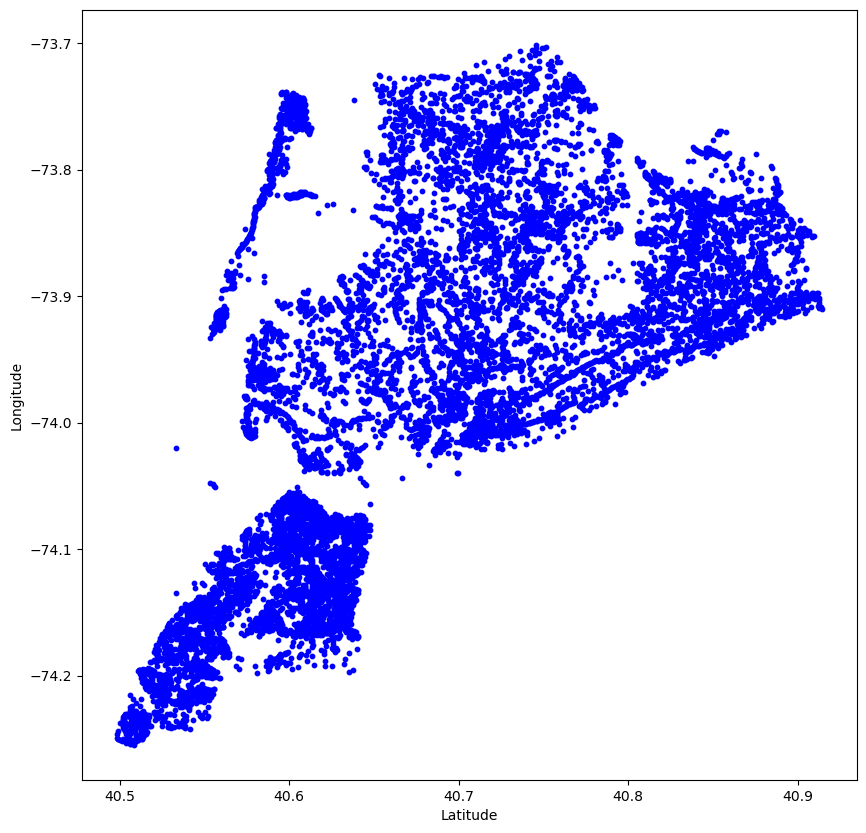

In [154]:
# plot longitude and latitude on a map
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# plot latitude on x and longitude on y
ax.scatter(grouped_df['Latitude'], grouped_df['Longitude'], color='blue', s=10)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

plt.show()

In [155]:
grouped_df['Borough'] = grouped_df['StreetCode'].apply(lambda code: code[:1])
grouped_df['StreetCode'] = grouped_df['StreetCode'].apply(lambda code: code[1:])

In [156]:
grouped_df.to_csv('../datasets/street_locations.csv', index=False)

In [157]:
grouped_df

,StreetCode,Street,Longitude,Latitude,Borough
0,00001,NY STATE ELLIS ISLAND BOUNDARY,-74.039600,40.699316,1
1,00008,"PATH-JOURNAL SQ- 33 ST LINE, PATH-NEWARK-HOBOK...",-74.005477,40.731529,1
2,00009,MANHATTAN CRUISE TERMINAL RAMP,-73.997058,40.767086,1
3,00013,FDNY TRAINING ACADEMY BOUNDARY,-73.920005,40.791703,1
4,00016,NORTH END WAY,-74.014838,40.714849,1
...,...,...,...,...,...
11644,97035,GOETHALS BRIDGE,-74.196748,40.635137,5
11645,97180,VERRAZZANO BRIDGE,-74.050806,40.604596,5
11646,97210,SI EXPRESSWAY ENTRANCE EASTBOUND,-74.064017,40.601377,5
11647,97223,KOREAN VETS PARKWAY EXIT EB,-74.189971,40.543849,5
